In [1]:
# Environment & device setup (CPU-only enforced)
import torch, os
os.environ['TORCH_DISABLE_TORCHDYNAMO'] = '1'  # ensure no dynamo/inductor surprises
os.environ.pop('PYTORCH_ENABLE_MPS_FALLBACK', None)

device = torch.device('cpu')
accelerator = 'cpu'
print(f'Using enforced CPU device: {device} | accelerator={accelerator}')

Using enforced CPU device: cpu | accelerator=cpu


In [2]:
# Path injection to ensure 'src' package resolvable when notebook launched from notebooks/
import sys
from pathlib import Path

_nb_root = Path.cwd()
# If current working dir ends with 'notebooks', ascend one level for repo root
_repo_root = _nb_root if (_nb_root / 'src').exists() else _nb_root.parent
_src = _repo_root / 'src'

if _src.exists():
    paths_added = []
    for p in (str(_repo_root), str(_src)):
        if p not in sys.path:
            sys.path.insert(0, p)
            paths_added.append(p)
    print('sys.path augmented with:', paths_added)
else:
    print('Warning: src directory not found at expected path:', _src)
    print('CWD:', _nb_root)
    print('Directory listing of parent:', [d for d in _nb_root.parent.iterdir()][:15])

try:
    import src
    print('Import test: src package available.')
except ModuleNotFoundError:
    print('ModuleNotFoundError persists. Head of sys.path:', sys.path[:8])
    # Provide troubleshooting hints
    print('Troubleshooting: Ensure you started Jupyter from repo root or run "cd .." before opening notebook.')
    raise

sys.path augmented with: ['/Users/zak/Repos/E-commerce-Demand-Forecasting', '/Users/zak/Repos/E-commerce-Demand-Forecasting/src']
Import test: src package available.


# N-BEATS Training Notebook

Train the minimal N-BEATS implementation on the panel parquet subset.

## Objectives
1. Load processed panel data (item_id, date, demand).
2. Create sliding window dataset (input_length -> forecast_length).
3. Train N-BEATS LightningModule for a few epochs.
4. Compute validation metrics (MAE, WAPE).
5. Save checkpoint + metrics artifacts.

If the panel file is missing, a synthetic dataset will be generated so the pipeline can run end-to-end.

In [3]:
# Imports (retain existing CPU device if already defined)
import os, json, math
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from src.models.nbeats_module import NBeatsModule, NBeatsConfig
from src.data.dataset_nbeats import PanelForecastDataset, PanelWindowConfig, split_dataset

# Only set device if not previously forced to CPU
if 'device' not in globals() or device.type != 'cpu':
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device('mps')
        accelerator = 'mps'
        backend_note = 'Using Apple Silicon MPS backend'
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        accelerator = 'gpu'
        backend_note = f'Using CUDA GPU: {torch.cuda.get_device_name(0)}'
    else:
        device = torch.device('cpu')
        accelerator = 'cpu'
        backend_note = 'Falling back to CPU'
else:
    backend_note = 'Preserving pre-set CPU device'

print('PyTorch version:', torch.__version__)
print('Lightning version:', pl.__version__)
print('Device:', device)
print('Accelerator:', accelerator)
print('Backend note:', backend_note)

PyTorch version: 2.8.0
Lightning version: 2.5.5
Device: cpu
Accelerator: cpu
Backend note: Preserving pre-set CPU device


In [4]:
# Configuration parameters (CPU training - 20 epochs)
PANEL_PATH = Path('data/processed/m5_panel_subset.parquet')
ARTIFACTS_DIR = Path('artifacts/models')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
INPUT_LENGTH = 28 * 4  # 112 days lookback
FORECAST_LENGTH = 30
BATCH_SIZE = 64  # CPU-friendly batch size
EPOCHS = 20     # Requested run length
LEARNING_RATE = 1e-3
NUM_STACKS = 3
BLOCKS_PER_STACK = 3
LAYER_WIDTH = 768
N_LAYERS = 4
DROPOUT = 0.05
MAX_ITEMS = 50
MAX_WINDOWS_PER_ITEM = 40
VAL_FRACTION = 0.1
SEED = 42
pl.seed_everything(SEED, workers=True)
print('Config -> epochs:', EPOCHS, '| batch_size:', BATCH_SIZE, '| stacks:', NUM_STACKS, 'blocks/stack:', BLOCKS_PER_STACK, 'layer_width:', LAYER_WIDTH)

Seed set to 42


Config -> epochs: 20 | batch_size: 64 | stacks: 3 blocks/stack: 3 layer_width: 768


In [5]:
# Load or create synthetic panel
if PANEL_PATH.exists():
    print('Loading panel from', PANEL_PATH)
    panel_df = pd.read_parquet(PANEL_PATH)
else:
    print('Panel not found. Creating synthetic panel for demo...')
    # Synthetic: 20 items, 200 days, simple seasonal pattern + noise
    import numpy as np
    items = [f'ITEM_{i:03d}' for i in range(20)]
    dates = pd.date_range('2024-01-01', periods=200, freq='D')
    rows = []
    for item in items:
        base = np.random.randint(5, 25)
        seasonal = np.sin(np.linspace(0, 12 * math.pi, len(dates))) * np.random.uniform(3, 8)
        noise = np.random.randn(len(dates)) * np.random.uniform(0.5, 2.0)
        demand = (base + seasonal + noise).clip(min=0).round(2)
        for d, val in zip(dates, demand):
            rows.append({'item_id': item, 'date': d, 'demand': float(val)})
    panel_df = pd.DataFrame(rows)
    PANEL_PATH.parent.mkdir(parents=True, exist_ok=True)
    panel_df.to_parquet(PANEL_PATH, index=False)
print(panel_df.head())
print('Panel shape:', panel_df.shape)

Loading panel from data/processed/m5_panel_subset.parquet
    item_id       date  demand
0  ITEM_000 2024-01-01   11.90
1  ITEM_000 2024-01-02   11.30
2  ITEM_000 2024-01-03   11.60
3  ITEM_000 2024-01-04   18.30
4  ITEM_000 2024-01-05   15.64
Panel shape: (4000, 3)


In [6]:
# Build dataset windows with chronological split
# Determine cutoff date for validation based on VAL_FRACTION of unique days
unique_dates = sorted(panel_df['date'].unique())
val_days = max(FORECAST_LENGTH, int(len(unique_dates) * VAL_FRACTION))
# Ensure we have enough history for validation windows
val_history_needed = INPUT_LENGTH + FORECAST_LENGTH
cutoff_index = len(unique_dates) - val_days
cutoff_date = unique_dates[cutoff_index]

# Train: all dates strictly before cutoff_date
train_df = panel_df[panel_df['date'] < cutoff_date]
# Validation: last segment plus required preceding history window
val_start_history_date = unique_dates[max(0, cutoff_index - (val_history_needed - 1))]
val_df = panel_df[panel_df['date'] >= val_start_history_date]

print('Cutoff date for validation segment:', cutoff_date)
print('Train date range:', train_df['date'].min(), '->', train_df['date'].max(), '| rows:', len(train_df))
print('Val+history date range:', val_df['date'].min(), '->', val_df['date'].max(), '| rows:', len(val_df))

# Persist temporary parquet shards (avoids modifying original panel file)
train_path = PANEL_PATH.parent / 'm5_panel_subset_train.parquet'
val_path = PANEL_PATH.parent / 'm5_panel_subset_val.parquet'
train_df.to_parquet(train_path, index=False)
val_df.to_parquet(val_path, index=False)

cfg_ds = PanelWindowConfig(input_length=INPUT_LENGTH, forecast_length=FORECAST_LENGTH, max_items=MAX_ITEMS, max_windows_per_item=MAX_WINDOWS_PER_ITEM)
train_ds = PanelForecastDataset(train_path, cfg_ds)
val_ds = PanelForecastDataset(val_path, cfg_ds)
print('Windows -> train:', len(train_ds), 'val:', len(val_ds))
# Inspect one sample
x0, y0 = train_ds[0]
print('Sample shapes -> x:', x0.shape, 'y:', y0.shape)

Cutoff date for validation segment: 2024-06-19 00:00:00
Train date range: 2024-01-01 00:00:00 -> 2024-06-18 00:00:00 | rows: 3400
Val+history date range: 2024-01-30 00:00:00 -> 2024-07-18 00:00:00 | rows: 3420
Windows -> train: 580 val: 600
Sample shapes -> x: torch.Size([112]) y: torch.Size([30])


In [7]:
# DataLoaders (batch 512)
num_workers = 6  # adjust based on CPU cores
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=num_workers, persistent_workers=True)
print('Batches -> train:', len(train_loader), 'val:', len(val_loader), '| workers:', num_workers, '| batch_size:', BATCH_SIZE)

Batches -> train: 10 val: 10 | workers: 6 | batch_size: 64


In [8]:
# Initialize model
cfg_model = NBeatsConfig(input_length=INPUT_LENGTH, forecast_length=FORECAST_LENGTH, learning_rate=LEARNING_RATE, num_stacks=NUM_STACKS, num_blocks_per_stack=BLOCKS_PER_STACK, layer_width=LAYER_WIDTH, n_layers=N_LAYERS, dropout=DROPOUT)
model = NBeatsModule(cfg_model).to(device)
print(model)

NBeatsModule(
  (stacks): ModuleList(
    (0-2): 3 x ModuleList(
      (0-2): 3 x NBeatsBlock(
        (fc): Sequential(
          (0): Linear(in_features=112, out_features=768, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.05, inplace=False)
          (3): Linear(in_features=768, out_features=768, bias=True)
          (4): ReLU()
          (5): Dropout(p=0.05, inplace=False)
          (6): Linear(in_features=768, out_features=768, bias=True)
          (7): ReLU()
          (8): Dropout(p=0.05, inplace=False)
          (9): Linear(in_features=768, out_features=768, bias=True)
          (10): ReLU()
          (11): Dropout(p=0.05, inplace=False)
        )
        (backcast_head): Linear(in_features=768, out_features=112, bias=True)
        (forecast_head): Linear(in_features=768, out_features=30, bias=True)
      )
    )
  )
  (loss_fn): MSELoss()
)


In [9]:
# Optional experimental torch.compile step (PyTorch 2.x)
import torch

if hasattr(torch, 'compile'):
    compile_mode = 'reduce-overhead'  # alternatives: 'max-autotune', 'default'
    try:
        # For MPS backend, fullgraph=False tends to be safer; dynamic shapes may break some passes.
        model = torch.compile(model, mode=compile_mode, fullgraph=False)
        print(f'Model compiled successfully with torch.compile (mode={compile_mode}).')
    except Exception as e:
        print('torch.compile failed:', type(e).__name__, str(e)[:300])
        print('Falling back to original (uncompiled) model.')
else:
    print('torch.compile not available in this PyTorch build.')

Model compiled successfully with torch.compile (mode=reduce-overhead).


In [10]:
# CPU-only mode: skip torch.compile (no benefit vs risk of overhead here)
print('CPU-only mode: skipping torch.compile. Model remains uncompiled.')

CPU-only mode: skipping torch.compile. Model remains uncompiled.


In [11]:
# 📊 Metric Interpretation & Overfitting Guide (updated for scaled run)
# Refer to earlier explanations. After scaling model, monitor:
#  - train_loss vs val_loss divergence
#  - val_wape flattening
#  - potential instability if precision < 32 on MPS
# If OOM occurs, reduce BATCH_SIZE first, then LAYER_WIDTH.


In [15]:
# Simplified CPU training cell (20 epochs) with metrics recorder callback
import torch, pytorch_lightning as pl
from torch.utils.data import DataLoader

class EpochMetricsRecorder(pl.Callback):
    def __init__(self):
        self.history = []
    def on_validation_epoch_end(self, trainer, pl_module):
        cm = trainer.callback_metrics
        # Extract metrics if present
        entry = {
            'epoch': trainer.current_epoch + 1,
            'train_loss': float(cm.get('train_loss', float('nan'))),
            'val_loss': float(cm.get('val_loss', float('nan'))),
            'train_wape': float(cm.get('train_wape', float('nan'))),
            'val_wape': float(cm.get('val_wape', float('nan'))),
            'train_accuracy': float(cm.get('train_accuracy', float('nan'))),
            'val_accuracy': float(cm.get('val_accuracy', float('nan'))),
            'train_mae': float(cm.get('train_mae', float('nan'))),
            'val_mae': float(cm.get('val_mae', float('nan')))
        }
        self.history.append(entry)

print('\n=== CPU Training (20 epochs) ===')
print(f'Device: {device} | Epochs: {EPOCHS} | Batch size: {BATCH_SIZE}')
assert device.type == 'cpu', 'Device not CPU; run the environment cell first.'

model.train().to(device)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

recorder = EpochMetricsRecorder()
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='cpu', devices=1, log_every_n_steps=5, enable_progress_bar=True, callbacks=[recorder])
trainer.fit(model, train_loader, val_loader)
print('CPU 20-epoch training complete. Recorded', len(recorder.history), 'epochs of metrics.')

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | stacks  | ModuleList | 17.7 M | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
17.7 M    Trainable params
0         Non-trainable params
17.7 M    Total params
70.839    Total estimated model params size (MB)
149       Modules in train mode
0         Modules in eval mode
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cor


=== CPU Training (20 epochs) ===
Device: cpu | Epochs: 20 | Batch size: 64


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/zak/anaconda3/envs/DataCamp/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


CPU 20-epoch training complete. Recorded 21 epochs of metrics.


,epoch,train_loss,val_loss,train_wape,val_wape,train_accuracy,val_accuracy,train_mae,val_mae
16,16,2.183736,2.216022,7.317486,7.361386,92.682518,92.638611,1.167129,1.159037
17,17,2.124172,2.177101,7.237281,7.338358,92.762726,92.661644,1.152623,1.154521
18,18,2.054872,2.170853,7.101155,7.331448,92.898849,92.668564,1.132589,1.153135
19,19,1.996591,2.282263,7.036947,7.465482,92.963051,92.534515,1.122152,1.176294
20,20,1.969034,2.245204,6.988431,7.468274,93.011566,92.531723,1.113718,1.175143


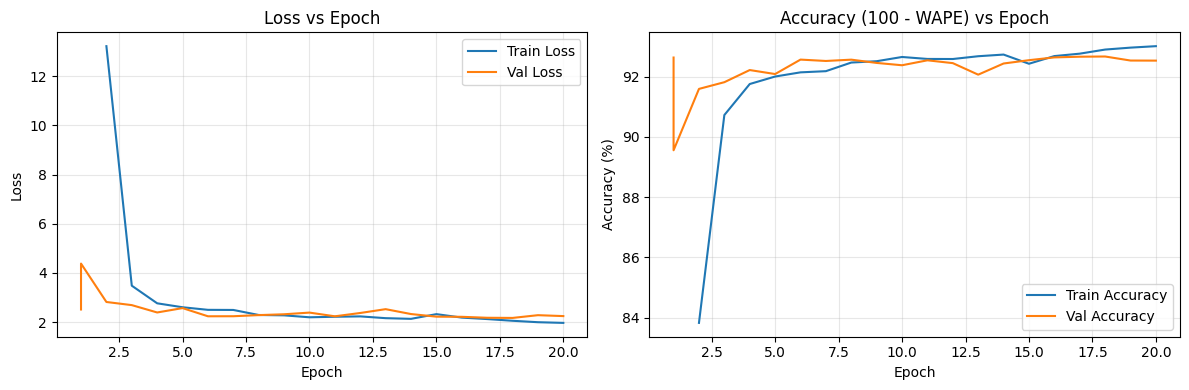

In [16]:
# Plot training & validation loss and accuracy vs epochs
import pandas as pd, matplotlib.pyplot as plt

if 'recorder' not in globals() or not getattr(recorder, 'history', None):
    print('No recorded history found. Re-run training cell with EpochMetricsRecorder.')
else:
    df = pd.DataFrame(recorder.history)
    display(df.tail())
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(df['epoch'], df['train_loss'], label='Train Loss')
    axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss vs Epoch'); axes[0].legend(); axes[0].grid(alpha=0.3)
    axes[1].plot(df['epoch'], df['train_accuracy'], label='Train Accuracy')
    axes[1].plot(df['epoch'], df['val_accuracy'], label='Val Accuracy')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)'); axes[1].set_title('Accuracy (100 - WAPE) vs Epoch'); axes[1].legend(); axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Save artifacts (derive metrics from trainer & recorder)
import json, torch, pandas as pd

if 'trainer' not in globals() or 'model' not in globals():
    print('Training objects not found. Re-run the training cell before saving artifacts.')
else:
    # Extract final validation metrics from trainer.callback_metrics
    cm = trainer.callback_metrics
    final_val_loss = float(cm.get('val_loss', float('nan')))
    final_val_mae = float(cm.get('val_mae', float('nan')))
    final_val_wape = float(cm.get('val_wape', float('nan')))
    final_val_accuracy = float(cm.get('val_accuracy', float('nan')))

    # Aggregate (mean) metrics across recorded epochs for additional context
    if 'recorder' in globals() and getattr(recorder, 'history', None):
        df_hist = pd.DataFrame(recorder.history)
        mean_val_loss = float(df_hist['val_loss'].mean())
        mean_val_mae = float(df_hist['val_mae'].mean())
        mean_val_wape = float(df_hist['val_wape'].mean())
        mean_val_accuracy = float(df_hist['val_accuracy'].mean())
    else:
        mean_val_loss = mean_val_mae = mean_val_wape = mean_val_accuracy = float('nan')

    CKPT_PATH = ARTIFACTS_DIR / 'nbeats_notebook.ckpt'
    torch.save(model.state_dict(), CKPT_PATH)

    metrics = {
        'final_val_loss': final_val_loss,
        'final_val_mae': final_val_mae,
        'final_val_wape': final_val_wape,
        'final_val_accuracy': final_val_accuracy,
        'mean_val_loss': mean_val_loss,
        'mean_val_mae': mean_val_mae,
        'mean_val_wape': mean_val_wape,
        'mean_val_accuracy': mean_val_accuracy,
        'config': cfg_model.__dict__,
        'n_train_windows': len(train_ds),
        'n_val_windows': len(val_ds),
        'history': recorder.history if 'recorder' in globals() else []
    }

    with open(ARTIFACTS_DIR / 'nbeats_notebook_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    print('Saved checkpoint ->', CKPT_PATH)
    print('Saved metrics ->', ARTIFACTS_DIR / 'nbeats_notebook_metrics.json')

NameError: name 'avg_loss' is not defined

## Next Steps
- Integrate with backtesting harness.
- Add basis (trend/seasonality) blocks for improved decomposition.
- Introduce quantile heads for probabilistic forecasts.
- Add per-item embeddings & categorical covariates.
- Promote best checkpoint to API service for live forecasts.